<h1>Улучшение сходимости нейросетей</h1>

In [53]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

In [54]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [55]:
images_train, labels_train = next(iter(train_loader))

In [56]:
def init_layer(layer, mean=0, std=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

<h3>1. Реализация Xavier</h3>

In [57]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

std_Xav1 = (6 / (28*28 + 500)) ** 0.5
std_Xav2 = (6 / (500 + 10)) ** 0.5
init_layer(layer_1, -std_Xav1, std_Xav1)
init_layer(layer_2, std_Xav2, std_Xav2)

In [58]:
network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.98772132396698
forward 0.7804168462753296
backward 0.050552502274513245
backward 0.01613539643585682


C:\Users\INadtochii\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


При инициализации весов методом **He** в семинаре получились следующие значения:
- forward 0.9945185780525208
- forward 0.12716735899448395
- backward 0.019999997690320015
- backward 0.038504574447870255

<br>В итоге Xavier справился лучше с форвардом чем He, но backward изменения практически неощутимы

<h3>2.1. Реализация DropConnect</h3>

In [76]:
class DropConnect(nn.Module):
    def __init__(self, p=0.5):
        super(DropConnect, self).__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.ones_like(x).bernoulli_(1 - self.p) / (1 - self.p)
            mask = mask.requires_grad_(False)
            return x * mask
        else:
            return x * (1 - self.p)

<h3>2.2. Сравнение DropOut и DropConnect</h3>

In [77]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.ones_like(x).bernoulli_(1 - self.p) / (1 - self.p)
            mask = mask.requires_grad_(False)
            return x * mask
        else:
            return x * (1 - self.p)

In [78]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()
        channels = 1
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.final_part = final_part
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [79]:
def train_network(network, train_loader, val_loader, epochs=10, lr=0.001, device='cpu'):
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    loss_fn = nn.NLLLoss()
    
    logs = {
        'train_losses': [],
        'val_losses': []
    }
    
    for epoch in range(epochs):
        network.train()
        train_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = network(images)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(images)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        train_loss /= len(train_loader.dataset)
        logs['train_losses'].append(train_loss)
        
        network.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = network(images)
                loss = loss_fn(output, labels)
                val_loss += loss.item() * images.size(0)
            val_loss /= len(val_loader.dataset)
            logs['val_losses'].append(val_loss)
        
        print(f'Test Epoch: {epoch}\tVal Loss: {val_loss:.6f}')
    
    return logs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [80]:
dropout_layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]
dropout_network = TestNetwork(nn.Sequential(*dropout_layers)).to(device)

dropconnect_layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    DropConnect(),
    nn.Linear(128, 128),
    nn.ReLU(),
    DropConnect(),
    nn.Linear(128, 10)
]
dropconnect_network = TestNetwork(nn.Sequential(*dropconnect_layers)).to(device)

In [81]:
print("Training Dropout Network...")
dropout_logs = train_network(dropout_network, train_loader, test_loader, epochs=10, device=device)

print("\nTraining DropConnect Network...")
dropconnect_logs = train_network(dropconnect_network, train_loader, test_loader, epochs=10, device=device)

Training Dropout Network...
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301797
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.736053
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.405871
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.306919
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.286754
Test Epoch: 0	Val Loss: 0.760673
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.331707
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.245163
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.367996
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.206033
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.226706
Test Epoch: 1	Val Loss: 0.579373
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.282286
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.356141
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.172434
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.220486
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.127220
Test Epoch: 2	Val Loss: 0.516000
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.232689
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.243201
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.

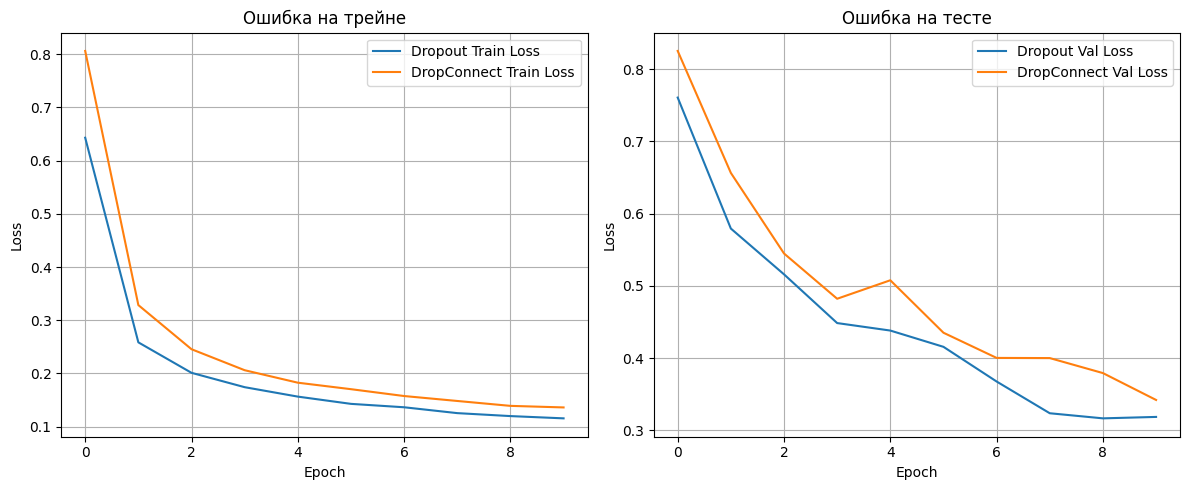

In [82]:
epochs = list(range(10))
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, dropout_logs['train_losses'], label='Dropout Train Loss')
plt.plot(epochs, dropconnect_logs['train_losses'], label='DropConnect Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Ошибка на трейне')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, dropout_logs['val_losses'], label='Dropout Val Loss')
plt.plot(epochs, dropconnect_logs['val_losses'], label='DropConnect Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Ошибка на тесте')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

В итоге разница поведения функции потерь при использовании Dropout или DropConnect минимальна, DropConnect отрабатывает немного лучше, но из за сложности реализации (Dropout можно использовать из библиотеки), на мой взгляд, выгоднее использовать именно Dropout. <br>

Попробуем использовать менеее агрессивный подход зануления нейронов/весов, используя p=0.3 вместо дефолтного p=0.5

In [66]:
dropout_layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(p=0.3),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(p=0.3),
    nn.Linear(128, 10)
]
dropout_network = TestNetwork(nn.Sequential(*dropout_layers)).to(device)

dropconnect_layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    DropConnect(p=0.3),
    nn.Linear(128, 128),
    nn.ReLU(),
    DropConnect(p=0.3),
    nn.Linear(128, 10)
]
dropconnect_network = TestNetwork(nn.Sequential(*dropconnect_layers)).to(device)

In [67]:
print("Training Dropout Network...")
dropout_logs = train_network(dropout_network, train_loader, test_loader, epochs=10, device=device)

print("\nTraining DropConnect Network...")
dropconnect_logs = train_network(dropconnect_network, train_loader, test_loader, epochs=10, device=device)

Training Dropout Network...
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.315148
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.499572
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.379560
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.251776
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.203809
Test Epoch: 0	Val Loss: 0.269314
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.291520
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.153599
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.132706
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.178451
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.169629
Test Epoch: 1	Val Loss: 0.181571
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.106574
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.145094
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.160143
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.112487
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.087487
Test Epoch: 2	Val Loss: 0.129725
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.102127
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.088195
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.

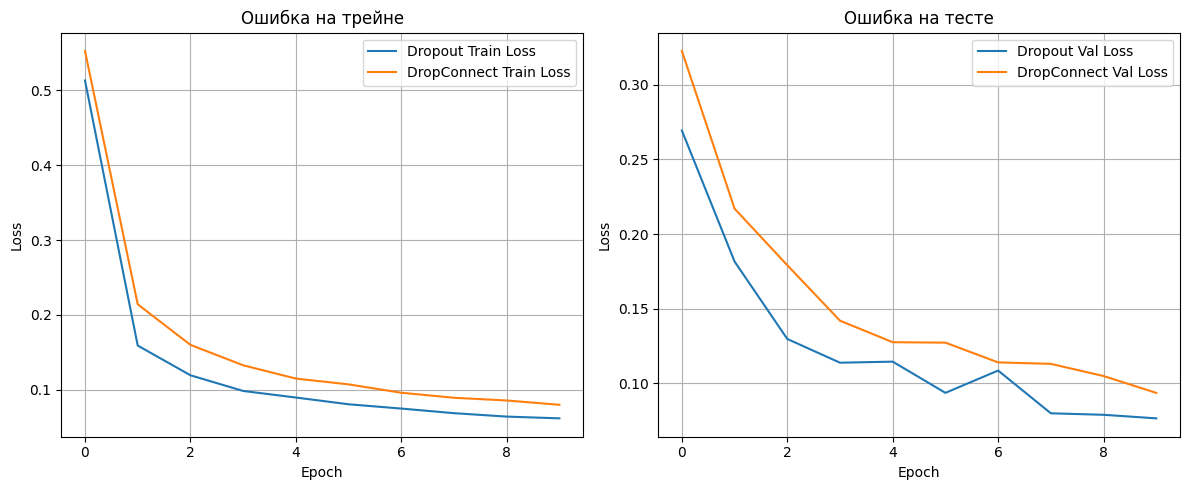

In [68]:
epochs = list(range(10))
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, dropout_logs['train_losses'], label='Dropout Train Loss')
plt.plot(epochs, dropconnect_logs['train_losses'], label='DropConnect Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Ошибка на трейне')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, dropout_logs['val_losses'], label='Dropout Val Loss')
plt.plot(epochs, dropconnect_logs['val_losses'], label='DropConnect Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Ошибка на тесте')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Результат оказался практически идентичным.

<h3>3.1. Реализация LayerNormalization</h3>

In [69]:
class LayerNormalization(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(1, num_features))
        self.beta = nn.Parameter(torch.zeros(1, num_features))

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        std = x.std(dim=1, keepdim=True)
        output = (x - mean) / (std + self.eps)
        output = output * self.gamma + self.beta 
        return output

<h3>3.2. Cравнение обучения нейросети с использованием нормализации между всеми слоями и без нее</h3>

In [70]:
base_layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]
base_network = TestNetwork(nn.Sequential(*base_layers)).to(device)

layernorm_layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNormalization(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNormalization(128),
    nn.Linear(128, 10)
]
layernorm_network = TestNetwork(nn.Sequential(*layernorm_layers)).to(device)

In [71]:
print("Training Base Network (No LayerNorm)...")
base_logs = train_network(base_network, train_loader, test_loader, epochs=10, device=device)

print("\nTraining LayerNorm Network...")
layernorm_logs = train_network(layernorm_network, train_loader, test_loader, epochs=10, device=device)

Training Base Network (No LayerNorm)...
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.295605
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.774607
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.510115
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.552170
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.231542
Test Epoch: 0	Val Loss: 0.241044
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.268016
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.281357
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.165734
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.237398
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.127541
Test Epoch: 1	Val Loss: 0.158435
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.253360
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.109180
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.236534
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.155185
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.086057
Test Epoch: 2	Val Loss: 0.119675
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.103374
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.113538
Train Epoch: 3 [25600/60000 (43

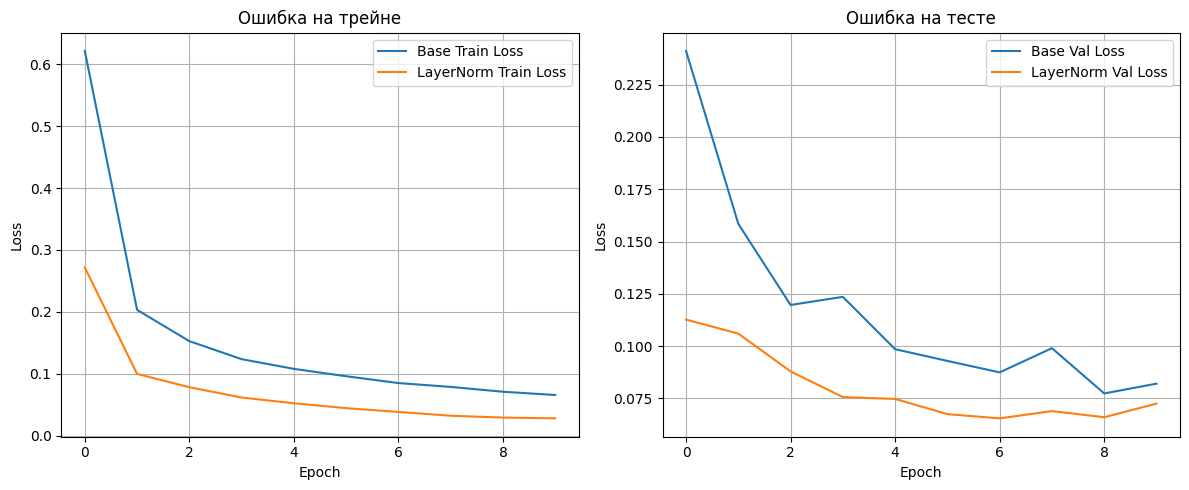

In [72]:
epochs = list(range(10))
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, base_logs['train_losses'], label='Base Train Loss')
plt.plot(epochs, layernorm_logs['train_losses'], label='LayerNorm Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Ошибка на трейне')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, base_logs['val_losses'], label='Base Val Loss')
plt.plot(epochs, layernorm_logs['val_losses'], label='LayerNorm Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Ошибка на тесте')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**В итоге:** <br>
Модель с нормализацией показала небольшуб ошибку вначале обучения, но на тесте под конец сравнялась со значением ошибки базовой модели